In [125]:
import pandas as pd
from statsmodels.formula.api import ols
from moexalgo import Ticker, session

# session.TOKEN = 

ticker = 'SBER'
ticker_2 = Ticker(ticker)

start_date = '2024-01-01'
end_date = '2025-04-22'
data = ticker_2.tradestats(start=start_date, end=end_date)

columns_to_include = ['tradedate', 'tradetime', 'pr_open', 'pr_high', 'pr_low', 'pr_close', 'vol', 'pr_vwap', 'vol_b', 'vol_s']
# Создание нового DataFrame
data_2 = data[columns_to_include]

In [126]:
# Преобразуем tradedate в формат datetime
data_2['tradedate'] = pd.to_datetime(data_2['tradedate'])

# Группируем данные по дате
data_3 = data_2.groupby('tradedate').agg(
    pr_open=('pr_open', 'first'),  # Первое значение open
    pr_high=('pr_high', 'max'),    # Максимальное значение high
    pr_low=('pr_low', 'min'),      # Минимальное значение low
    pr_close=('pr_close', 'last'), # Последнее значение close
    pr_vwap=('pr_vwap',)
    vol=('vol', 'sum'),           # Суммарный объем
    vol_b=('vol_b', 'sum'),       # Суммарный объем покупок
    vol_s=('vol_s', 'sum')        # Суммарный объем продаж
)

# Рассчитываем дельту
data_3['дельта'] = (data_3['vol_b'] - data_3['vol_s']) / data_3['vol'] *100

# Оставляем только нужные столбцы
data_3 = data_3[['pr_open', 'pr_high', 'pr_low', 'pr_close', 'дельта']]

print(data_3)

            pr_open  pr_high  pr_low  pr_close     дельта
tradedate                                                
2024-01-03   271.75   274.70  271.00    274.56  27.048987
2024-01-04   274.68   275.48  273.70    274.12 -16.578051
2024-01-05   274.30   274.69  272.80    273.62  -6.218262
2024-01-08   273.59   277.00  273.53    276.76  17.103691
2024-01-09   276.94   278.00  274.71    275.28   4.216465
...             ...      ...     ...       ...        ...
2024-03-27   294.45   295.11  293.47    295.10   7.242152
2024-03-28   295.51   299.30  295.51    299.00  19.492820
2024-03-29   299.37   299.50  298.00    298.72  -6.901107
2024-04-01   299.99   301.65  299.50    300.43   9.743676
2024-04-02   300.42   300.60  298.95    300.00  -6.818959

[63 rows x 5 columns]


C:\Users\Anton\AppData\Local\Temp\ipykernel_21484\433076038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['tradedate'] = pd.to_datetime(data_2['tradedate'])


In [127]:
data_3['close_+1'] = data_3['pr_close'].shift(-1)
data_3['open_+1'] = data_3['pr_open'].shift(-1)
data_3['res_next'] = data_3.apply(lambda row: 1 if row['close_+1'] - row['open_+1'] > 0 else -1, axis=1)
data_3 = data_3.iloc[:-1]
data_3['close'] = data_3['pr_close'] - data_3['pr_open']
data_3['high'] = data_3['pr_high'] - data_3['pr_open']
data_3['low'] = data_3['pr_low'] - data_3['pr_open']
print(data_3)

            pr_open  pr_high  pr_low  pr_close     дельта  close_+1  open_+1  \
tradedate                                                                      
2024-01-03   271.75   274.70  271.00    274.56  27.048987    274.12   274.68   
2024-01-04   274.68   275.48  273.70    274.12 -16.578051    273.62   274.30   
2024-01-05   274.30   274.69  272.80    273.62  -6.218262    276.76   273.59   
2024-01-08   273.59   277.00  273.53    276.76  17.103691    275.28   276.94   
2024-01-09   276.94   278.00  274.71    275.28   4.216465    274.49   275.30   
...             ...      ...     ...       ...        ...       ...      ...   
2024-03-26   294.44   295.82  293.04    294.11  -2.557359    295.10   294.45   
2024-03-27   294.45   295.11  293.47    295.10   7.242152    299.00   295.51   
2024-03-28   295.51   299.30  295.51    299.00  19.492820    298.72   299.37   
2024-03-29   299.37   299.50  298.00    298.72  -6.901107    300.43   299.99   
2024-04-01   299.99   301.65  299.50    

In [128]:
data_3.to_excel('data_candles.xlsx')

Learning rate set to 0.015045
0:	learn: 0.7551020	test: 0.6153846	best: 0.6153846 (0)	total: 6.51ms	remaining: 6.51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7692307692
bestIteration = 28

Shrink model to first 29 iterations.
Test Accuracy: 0.7692


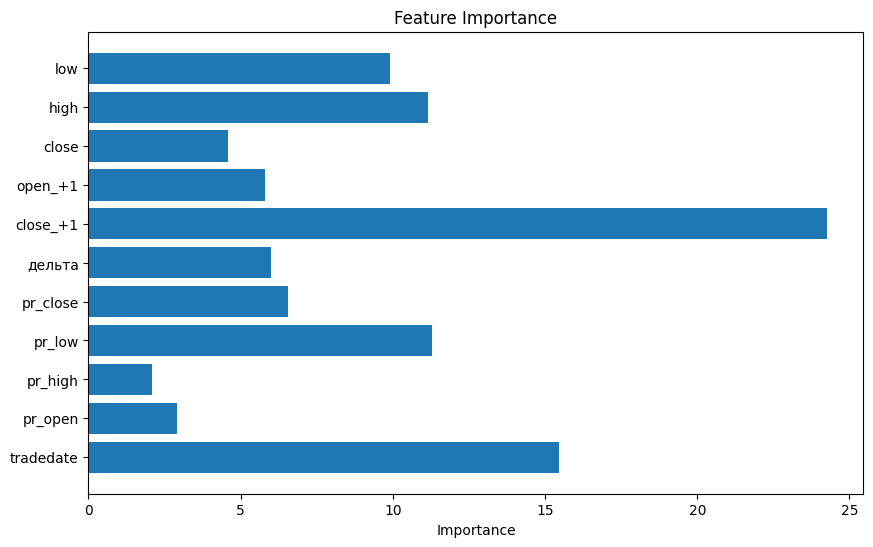

In [136]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

# Загрузка данных
df = pd.read_excel('data_candles.xlsx')

# # Сохраняем порядок временного ряда
# df = df[::-1].reset_index(drop=True)

# Разделение на признаки и целевую переменную
X = df.drop('res_next', axis=1)
y = df['res_next']

# Разделение на train/test с сохранением временного порядка
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Создание CatBoost Pool
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Параметры модели с Ordered Boosting
model = CatBoostClassifier(
    iterations=1000,
    boosting_type='Ordered',
    has_time=True,
    loss_function='Logloss',
    eval_metric='Accuracy',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
)

# Обучение модели
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# Оценка точности
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Анализ важности признаков
feature_importances = model.get_feature_importance()
feature_names = X.columns

# Визуализация важности признаков
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()
